In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import process_data.dire_and_coor as dc
import functions as func
import process_data.n_n_distance as nn

## 27 Oct
1. random walk training for single node
2. 14 in, 14 out
3. the input noise is normal distribution
4. the expected output of generator is 4 peaks: 0, 1/4, 1/2, 3/4
5. lr = 0.001, generator(sigmoid, sigmoid), discriminator(leaky relu, sigmoid)
6. adam is using

In [2]:
# load the model
import fnn.single_node as single_node
generator = single_node.GeneratorNet(14, 14)

In [24]:
def check_output_hist(gen, number_bin, z_dim, num_polymer):

    noise = func.get_noise(num_polymer, z_dim)
    output = gen(noise).data.numpy()
    output = output.reshape(1400000)

    plt.hist(output, density=True, bins=number_bin)
    plt.title('output of generator')
    plt.show()

    output = np.round(output * 4) / 4
    sns.histplot(output)
    plt.title('output of generator after round')
    plt.show()


def round_and_reshape(model, num_polymer, z_dim, shifted=True):
    # load model
    # get output
    noise = func.get_noise(num_polymer, z_dim)
    output = model(noise).data.numpy()
    # round and reshape output
    output = np.round(output * 4) / 4
    if shifted:
        output += (0.75/2)
    for i in range(len(output)):
        for j in range(len(output[i])):
            if output[i][j] == 1.:
                output[i][j] = 0
    directions_14 = output.reshape((num_polymer, 14, 1))
    directions = np.zeros((num_polymer, 15, 1))
    for i in range(len(directions)):
        directions[i] = np.vstack(([0], directions_14[i]))
    return directions

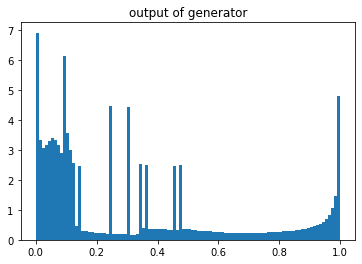

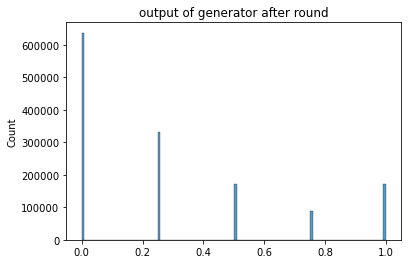

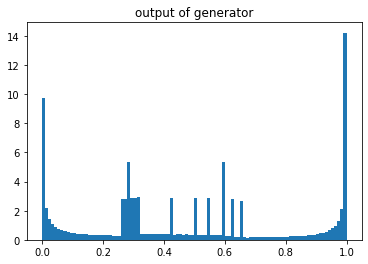

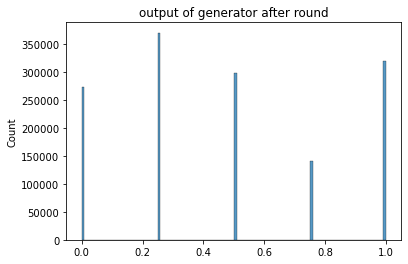

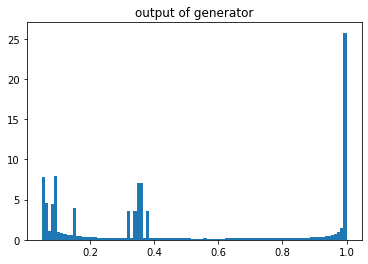

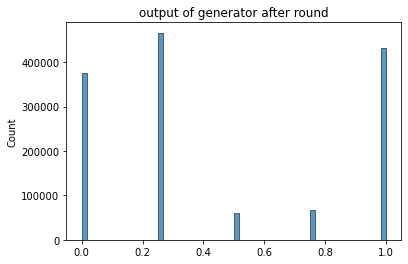

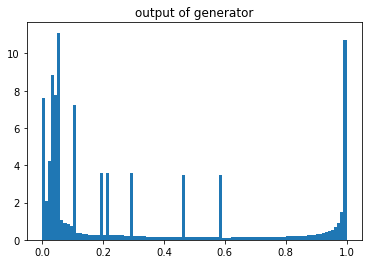

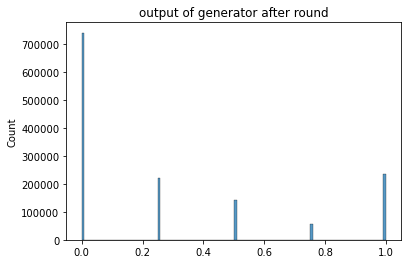

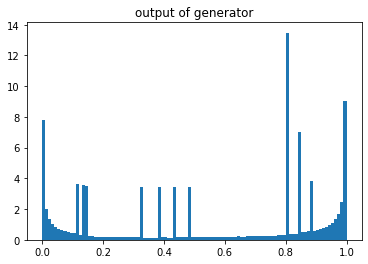

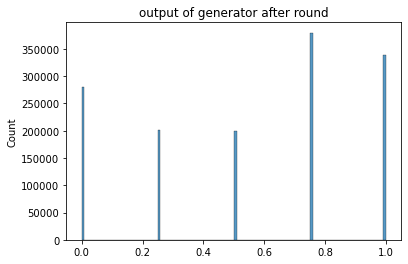

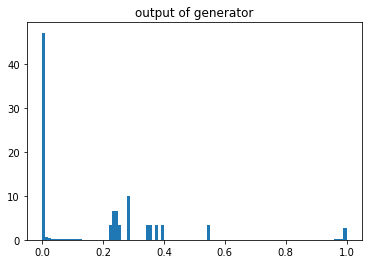

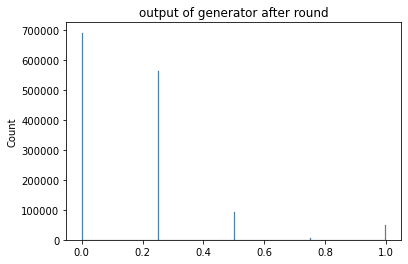

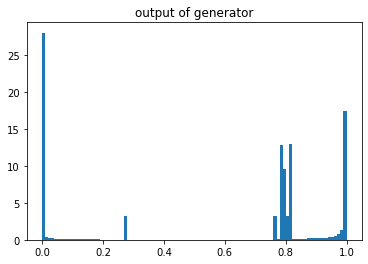

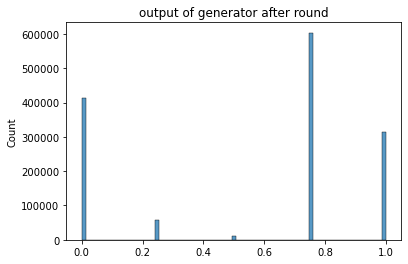

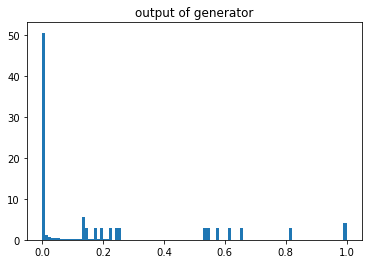

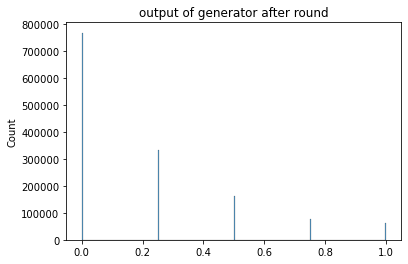

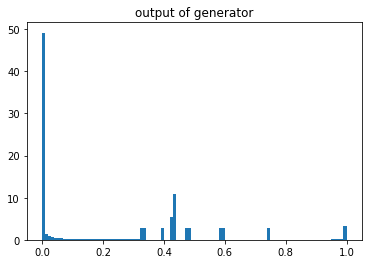

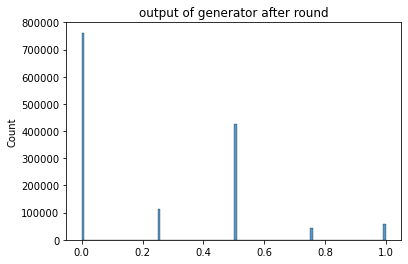

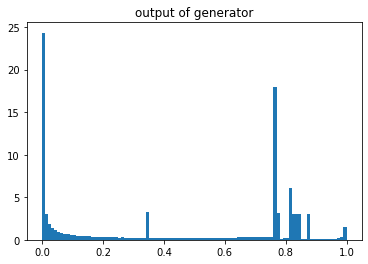

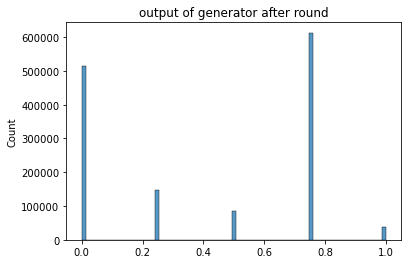

In [5]:
for i in range(1, 11):
    check_point = torch.load(f'../experiments/10_27/normal/single_node_gen_{100 * i}.pth.tar')
    generator.load_state_dict(check_point['gen_state_dict'])
    check_output_hist(generator, 100, 14, 100000)

In [9]:
noise = func.get_noise(100000, 14)
output = generator(noise).data.numpy()
for par in generator.parameters():
    print(par)

Parameter containing:
tensor([[-0.2444, -0.2168,  0.2370,  0.2615, -0.0728,  0.1754, -0.0077,  0.1578,
         -0.1883,  0.2020,  0.0210, -0.0960,  0.1804,  0.1230]],
       requires_grad=True)
Parameter containing:
tensor([0.2664], requires_grad=True)
Parameter containing:
tensor([[-0.6794],
        [-0.3654],
        [-0.9226],
        [-0.3719],
        [ 0.2671],
        [ 0.2983],
        [ 0.2511],
        [ 0.4529],
        [ 0.0430],
        [ 0.1764],
        [ 0.9597],
        [-0.9746],
        [-0.8132],
        [ 0.1801]], requires_grad=True)
Parameter containing:
tensor([-0.8561, -0.4822,  0.9511,  0.6684, -0.6863, -0.4201, -0.3102,  0.4627,
         0.0379, -0.2160,  0.9418, -0.5776,  0.2625, -0.3266],
       requires_grad=True)


In [12]:
directions = round_and_reshape(generator, 100000, 14)


In [13]:


coordinates = dc.direction_coordinate_three(directions, 16)

In [24]:

nn.n_n_distance(coordinates)


3.4749215818490065

## conclusion we can draw for now
1. the single node won't work for GAN, single node means no hidden layers, no matter how many

## Nov 1 result
#### 3 layers
1. shifted dataset
2. tanh functions for last layer of generator
3. dropout
4. 10000 epochs

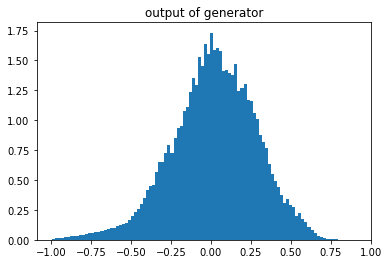

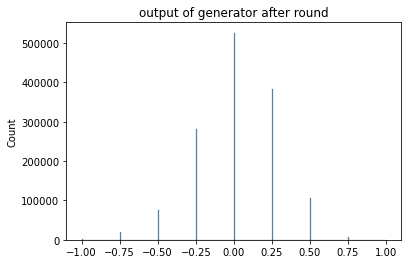

0.0


In [28]:
import fnn.four_layers as four_layers
generator = four_layers.GeneratorNet(14, 14)
for i in range(1, 11):
    check_point = torch.load(f'../experiments/11_3/batch_size_1024/four_layers_gen_{100 * i}.pth.tar')
    generator.load_state_dict(check_point['gen_state_dict'])
    check_output_hist(generator, 100, 14, 100000)
# directions = round_and_reshape(generator, 100000, 14, shifted=True)
# coordinates = dc.direction_coordinate_three(directions, 16)
# nndistance = nn.n_n_distance(coordinates)
# print(nndistance)